## LIBRARIES & SETUP

In [1]:
# --- CELL 1: LIBRARIES & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import os

# Set visual style
sns.set_style("whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


## DATA LOADING

In [2]:
# --- CELL 2: DATA LOADING ---
# Check if file exists, if not download it
if not os.path.exists('log2.csv'):
    print("Downloading dataset...")
    !curl -L -o firewall-dataset.zip https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip
    !unzip -o firewall-dataset.zip
    print("Download complete.")
else:
    print("Dataset already exists.")

# Load the dataset
df = pd.read_csv('log2.csv')

# Clean column names: strip spaces, lower case, replace special chars
df.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_").lower() for c in df.columns]

# Basic Data Cleaning
# Drop columns that are IDs or likely irrelevant for regression (like specific ports unless grouped)
# We keep 'action' for the qualitative interaction task later.
print("Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2809k    0 2809k    0     0  3236k      0 --:--:-- --:--:-- --:--:-- 3236k
Archive:  firewall-dataset.zip
 extracting: log2.csv                
Download complete.
Data Shape: (65532, 12)
Columns: ['source_port', 'destination_port', 'nat_source_port', 'nat_destination_port', 'action', 'bytes', 'bytes_sent', 'bytes_received', 'packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received']


,source_port,destination_port,nat_source_port,nat_destination_port,action,bytes,bytes_sent,bytes_received,packets,elapsed_time_sec,pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


## CORRELATION MATRIX

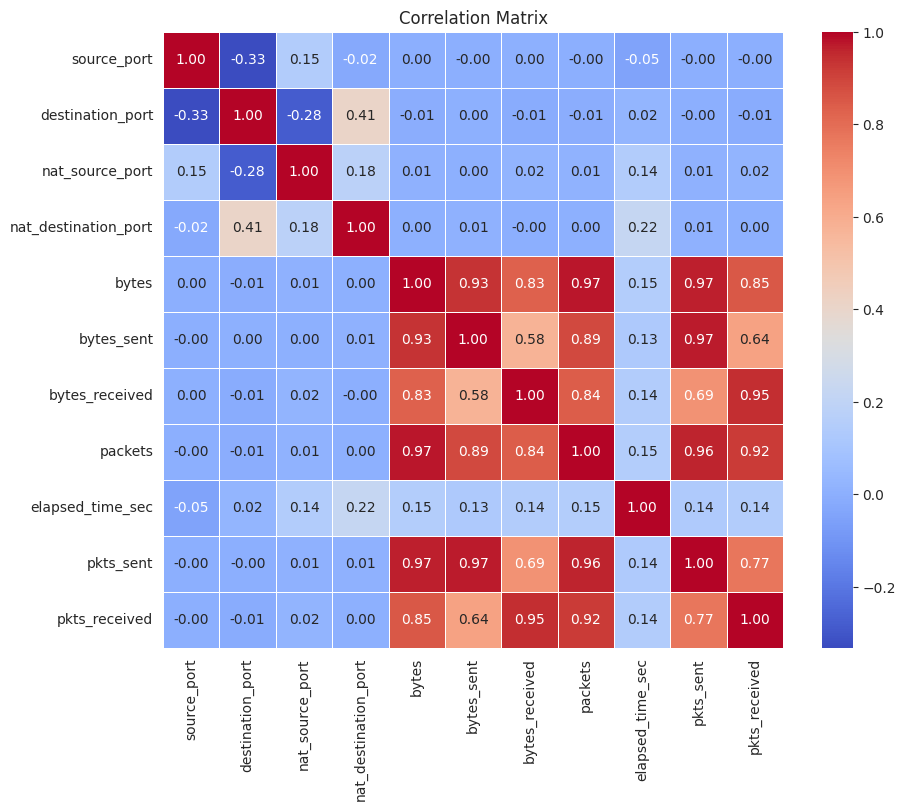

In [3]:
# --- CELL 3: CORRELATION MATRIX ---
# Select numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Based on this, we choose our Target (Y) and Predictors (X)
# Let's try to predict 'bytes' (Total Bytes) based on 'packets' (Total Packets)
# They usually have a high positive correlation.

## SINGLE PREDICTOR REGRESSION

                            OLS Regression Results                            
Dep. Variable:                  bytes   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                 1.230e+06
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        02:42:24   Log-Likelihood:            -1.0137e+06
No. Observations:               65532   AIC:                         2.027e+06
Df Residuals:                   65530   BIC:                         2.027e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.259e+04   4937.297     -2.549      0.0

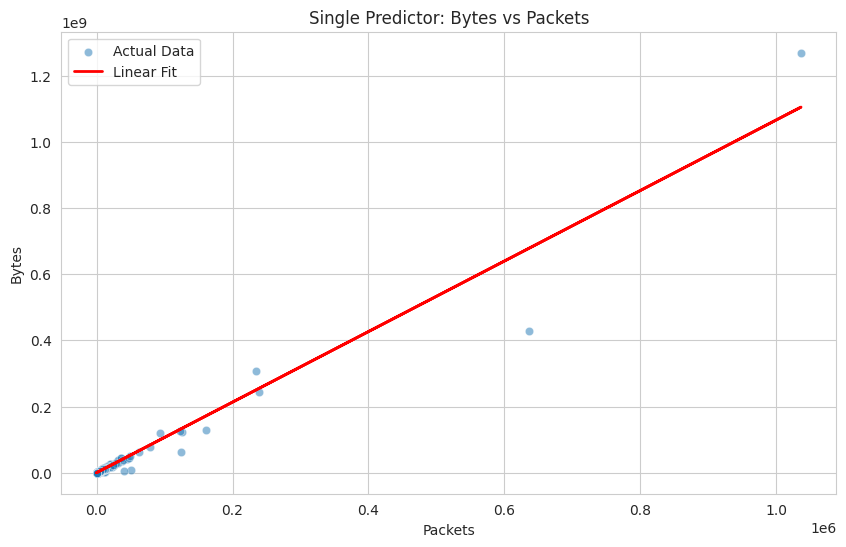

In [26]:
# --- CELL 4: SINGLE PREDICTOR REGRESSION ---

# 1. Define Variables
X_simple = df['packets']  # Predictor
Y_simple = df['bytes']    # Response

# 2. Add constant (intercept) for statsmodels
X_simple_const = sm.add_constant(X_simple)

# 3. Fit the model (OLS = Ordinary Least Squares)
model_simple = sm.OLS(Y_simple, X_simple_const).fit()

# 4. Print Summary (Includes Coefficients, t-stat, p-value, R-squared)
print(model_simple.summary())

# 5. Calculate Manual Metrics (RSS and RSE)
# RSS = Sum of Squared Residuals
rss = model_simple.ssr
# RSE = Residual Standard Error (sqrt of MSE)
rse = np.sqrt(model_simple.mse_resid)

print("\n--- Additional Metrics ---")
print(f"Residual Sum of Squares (RSS): {rss:,.2f}")
print(f"Residual Standard Error (RSE): {rse:,.2f}")
# print(f"Correlation (r): {np.sqrt(model_simple.rsquared):.4f}")
print(f"Correlation (r): {df['packets'].corr(df['bytes']):.4f}")

# 6. Plotting the Fit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_simple, y=Y_simple, alpha=0.5, label='Actual Data')
plt.plot(X_simple, model_simple.predict(X_simple_const), color='red', linewidth=2, label='Linear Fit')
plt.xlabel('Packets')
plt.ylabel('Bytes')
plt.title('Single Predictor: Bytes vs Packets')
plt.legend()
plt.show()

## Enhanced Plotting (Single Predictor)

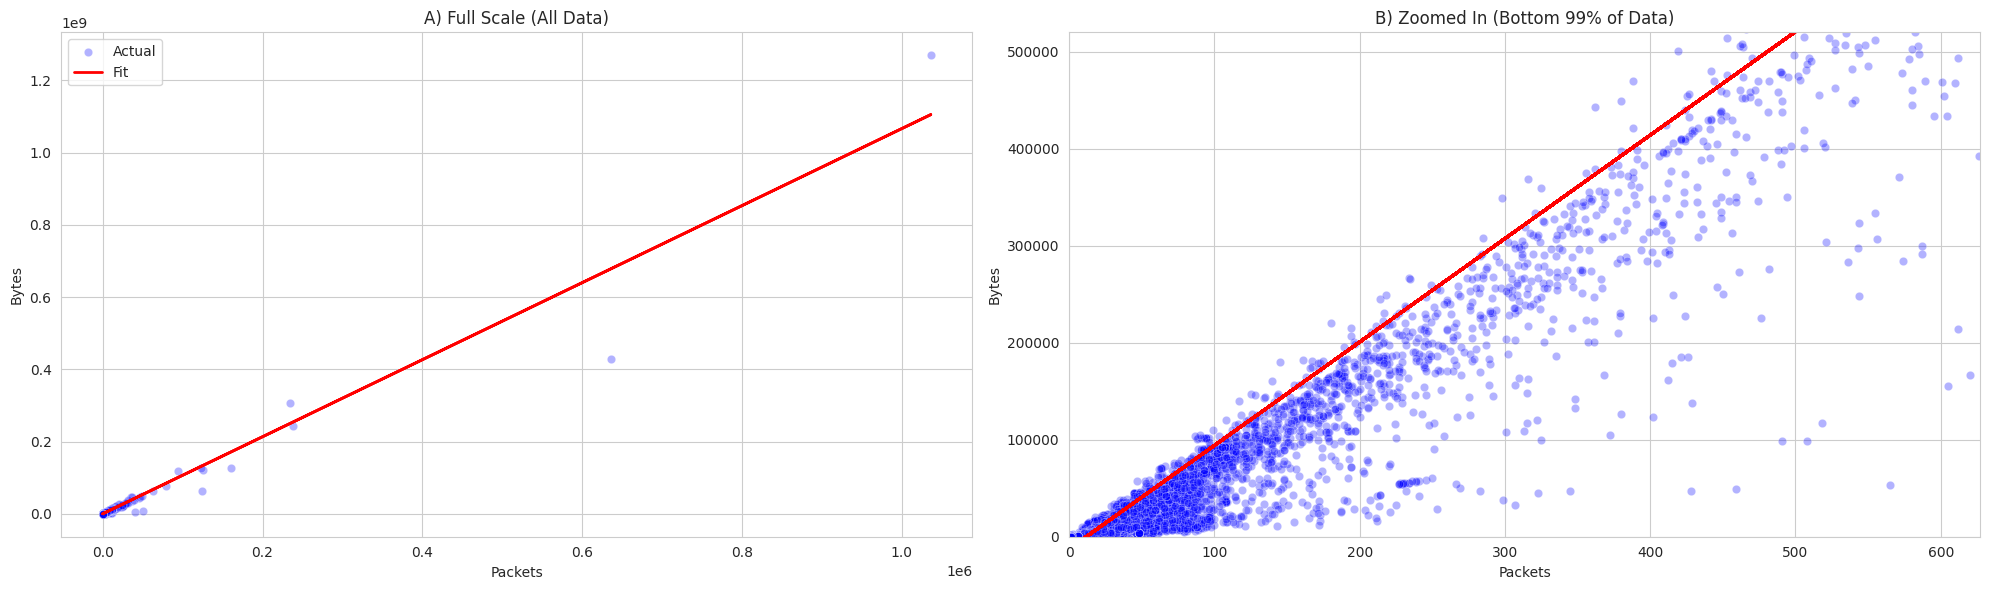

In [14]:
# 6. Enhanced Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot A: Original (Full Scale)
sns.scatterplot(x=X_simple, y=Y_simple, alpha=0.3, ax=axes[0], color='blue', label='Actual')
axes[0].plot(X_simple, model_simple.predict(X_simple_const), color='red', linewidth=2, label='Fit')
axes[0].set_title('A) Full Scale (All Data)')
axes[0].set_xlabel('Packets')
axes[0].set_ylabel('Bytes')
axes[0].legend()

# Plot B: Zoomed In (99th Percentile)
# We calculate the 99th percentile cutoff to ignore the massive outliers just for this view
p99_packets = np.percentile(X_simple, 99)
p99_bytes = np.percentile(Y_simple, 99)

sns.scatterplot(x=X_simple, y=Y_simple, alpha=0.3, ax=axes[1], color='blue')
axes[1].plot(X_simple, model_simple.predict(X_simple_const), color='red', linewidth=2)
axes[1].set_xlim(0, p99_packets)
axes[1].set_ylim(0, p99_bytes)
axes[1].set_title('B) Zoomed In (Bottom 99% of Data)')
axes[1].set_xlabel('Packets')
axes[1].set_ylabel('Bytes')


# # C) Hexbin Plot (Cleaner alternative to scatter for dense data)
# hb = axes[2].hexbin(X_simple, Y_simple, gridsize=50, cmap='Blues', xscale='log', yscale='log', mincnt=1)
# axes[2].set_title('C) Log-Log Density (Hexbin)')
# axes[2].set_xlabel('Packets (Log)')
# axes[2].set_ylabel('Bytes (Log)')
# cb = fig.colorbar(hb, ax=axes[2])
# cb.set_label('Count')

plt.tight_layout()
plt.show()

## MULTIPLE PREDICTORS & INTERACTION

In [6]:
# --- CELL 5: MULTIPLE PREDICTORS & INTERACTION ---

# A) Fit Multiple Regression
# Using 'packets', 'elapsed_time_sec', 'pkts_sent' to predict 'bytes'
X_multi = df[['packets', 'elapsed_time_sec', 'pkts_sent']]
Y_multi = df['bytes']
X_multi_const = sm.add_constant(X_multi)

model_multi = sm.OLS(Y_multi, X_multi_const).fit()
print("--- Multiple Regression Summary ---")
print(model_multi.summary())

# D) Prediction Example
# Let's predict bytes for a hypothetical inputs: 50 packets, 10 seconds elapsed, 25 packets sent
input_data = pd.DataFrame({'const': [1], 'packets': [50], 'elapsed_time_sec': [10], 'pkts_sent': [25]})
predicted_val = model_multi.predict(input_data)[0]
print(f"\nPredicted Bytes for (Packets=50, Time=10, Sent=25): {predicted_val:,.2f}")

# E) Interaction between Qualitative (action) and Quantitative (packets) variables
# We use the formula API for easier handling of categorical data
print("\n--- Interaction Model (Action * Packets) ---")
interaction_model = smf.ols(formula='bytes ~ packets * C(action)', data=df).fit()
print(interaction_model.summary())

# Note for Report: Check the interaction terms (e.g., packets:C(action)[T.drop])
# If the p-value is < 0.05, the relationship between packets and bytes is different for that action type.

--- Multiple Regression Summary ---
                            OLS Regression Results                            
Dep. Variable:                  bytes   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 5.418e+05
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        01:27:56   Log-Likelihood:            -1.0049e+06
No. Observations:               65532   AIC:                         2.010e+06
Df Residuals:                   65528   BIC:                         2.010e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cons

## MULTIPLE REGRESSION & VISUALIZATION

--- Multiple Regression Summary ---
                            OLS Regression Results                            
Dep. Variable:                  bytes   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 5.418e+05
Date:                Wed, 11 Feb 2026   Prob (F-statistic):               0.00
Time:                        01:48:30   Log-Likelihood:            -1.0049e+06
No. Observations:               65532   AIC:                         2.010e+06
Df Residuals:                   65528   BIC:                         2.010e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
cons

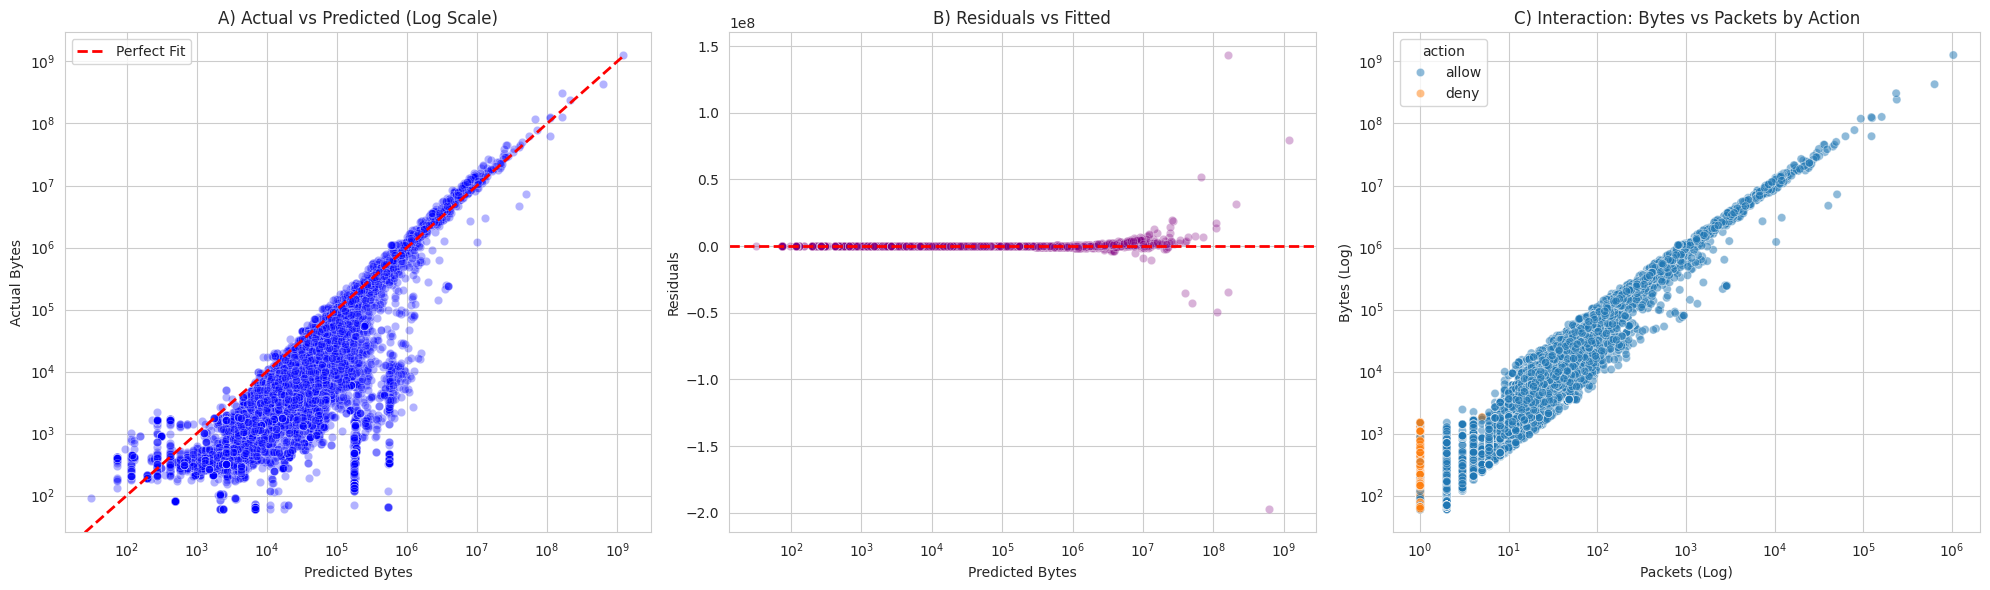


--- Interaction Statistical Test ---
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -2.118e+04   7270.651     -2.913      0.004   -3.54e+04   -6931.185
C(action)[T.deny]          2.114e+04   1.39e+05      0.152      0.879   -2.51e+05    2.93e+05
packets                    1066.5613      1.073    993.733      0.000    1064.458    1068.665
packets:C(action)[T.deny]  -937.4536   1.38e+05     -0.007      0.995   -2.71e+05    2.69e+05


In [15]:
# --- CELL 5: MULTIPLE REGRESSION & VISUALIZATION ---

# 1. Define Variables (Multiple Predictors)
# We use 'packets', 'elapsed_time_sec', and 'pkts_sent' to predict 'bytes'
X_multi = df[['packets', 'elapsed_time_sec', 'pkts_sent']]
Y_multi = df['bytes']
X_multi_const = sm.add_constant(X_multi)

# 2. Fit the Model
model_multi = sm.OLS(Y_multi, X_multi_const).fit()
print("--- Multiple Regression Summary ---")
print(model_multi.summary())

# 3. Calculate Predictions & Residuals for Plotting
y_pred = model_multi.predict(X_multi_const)
residuals = model_multi.resid

# 4. Visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot A: Actual vs Predicted (Log Scale)
# This shows how well the model fits across all scales.
sns.scatterplot(x=y_pred, y=Y_multi, alpha=0.3, ax=axes[0], color='blue')
# Add a diagonal "Perfect Fit" line
min_val = min(y_pred.min(), Y_multi.min())
max_val = max(y_pred.max(), Y_multi.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
axes[0].set_title('A) Actual vs Predicted (Log Scale)')
axes[0].set_xlabel('Predicted Bytes')
axes[0].set_ylabel('Actual Bytes')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()

# Plot B: Residuals vs Predicted
# Used to check for "Heteroscedasticity" (if errors get bigger as values get bigger).
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3, ax=axes[1], color='purple')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('B) Residuals vs Fitted')
axes[1].set_xlabel('Predicted Bytes')
axes[1].set_ylabel('Residuals')
# We use log scale on X to match the previous plot, helps see the spread better
axes[1].set_xscale('log')

# Plot C: Interaction Visualization (Action vs Packets)
# This answers Q2e: "Analyze Interactions between qualitative and quantitative Variables"
# We color the points by 'Action' to see if the slope changes.
top_actions = df['action'].value_counts().nlargest(2).index # Focus on top 2 actions (Allow/Drop)
df_filtered = df[df['action'].isin(top_actions)]

sns.scatterplot(x='packets', y='bytes', hue='action', data=df_filtered, alpha=0.5, ax=axes[2])
axes[2].set_title('C) Interaction: Bytes vs Packets by Action')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel('Packets (Log)')
axes[2].set_ylabel('Bytes (Log)')

plt.tight_layout()
plt.show()

# 5. Interaction Model Stats
# Mathematically confirm if the interaction is significant
print("\n--- Interaction Statistical Test ---")
interaction_model = smf.ols(formula='bytes ~ packets * C(action)', data=df_filtered).fit()
print(interaction_model.summary().tables[1])

## FEATURE SELECTION (FORWARD & BACKWARD)

In [19]:
# --- CELL 5.5: FEATURE SELECTION (FORWARD & BACKWARD) ---

# Define the pool of all potential numerical predictors
# We exclude 'bytes' (target) and 'action' (categorical, handled separately)
potential_features = ['packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received']
# Note: Ensure these columns exist in your df. If 'pkts_received' isn't there, remove it.

# Keep only features that actually exist in the dataset (avoids KeyError)
potential_features = [f for f in potential_features if f in df.columns]
print('Available features for selection:', potential_features)

target = 'bytes'

print("--- 1. Forward Selection ---")
# Start with no variables, add the best one step-by-step
selected_features = []
remaining_features = potential_features.copy()

while remaining_features:
    best_pval = 1.0
    best_feature = None

    for feature in remaining_features:
        # Try adding this feature to what we already have
        trial_features = selected_features + [feature]
        X_trial = df[trial_features]
        X_trial = sm.add_constant(X_trial)
        model = sm.OLS(df[target], X_trial).fit()

        # Look at the p-value of the *newly added* feature
        pval = model.pvalues[feature]

        if pval < best_pval:
            best_pval = pval
            best_feature = feature

    # If the best candidate is significant (p < 0.05), keep it
    if best_pval < 0.05:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Added '{best_feature}' (p-value: {best_pval:.4e})")
    else:
        print("No more significant features found.")
        break

print(f"Final Forward Selection: {selected_features}")


print("\n--- 2. Backward Selection ---")
# Start with ALL variables, remove the worst one step-by-step
current_features = potential_features.copy()

while current_features:
    X_curr = df[current_features]
    X_curr = sm.add_constant(X_curr)
    model = sm.OLS(df[target], X_curr).fit()

    # Find the feature with the HIGHEST p-value (worst predictor)
    # We skip 'const' because we always want an intercept
    pvalues = model.pvalues.drop('const')
    worst_pval = pvalues.max()
    worst_feature = pvalues.idxmax()

    if worst_pval > 0.05:
        print(f"Removed '{worst_feature}' (p-value: {worst_pval:.4e})")
        current_features.remove(worst_feature)
    else:
        print("All remaining features are significant.")
        break

print(f"Final Backward Selection: {current_features}")


--- 1. Forward Selection ---
Added 'packets' (p-value: 0.0000e+00)
Added 'pkts_sent' (p-value: 0.0000e+00)
Added 'elapsed_time_sec' (p-value: 7.3342e-26)
Added 'pkts_received' (p-value: 1.2984e-06)
Final Forward Selection: ['packets', 'pkts_sent', 'elapsed_time_sec', 'pkts_received']

--- 2. Backward Selection ---
All remaining features are significant.
Final Backward Selection: ['packets', 'elapsed_time_sec', 'pkts_sent', 'pkts_received']


## POLYNOMIAL REGRESSION

Linear Regression RMSE: 418,728.70
Polynomial Regression (Deg 2) RMSE: 511,282.77
------------------------------
Result: Polynomial regression fits WORSE (Overfitting).


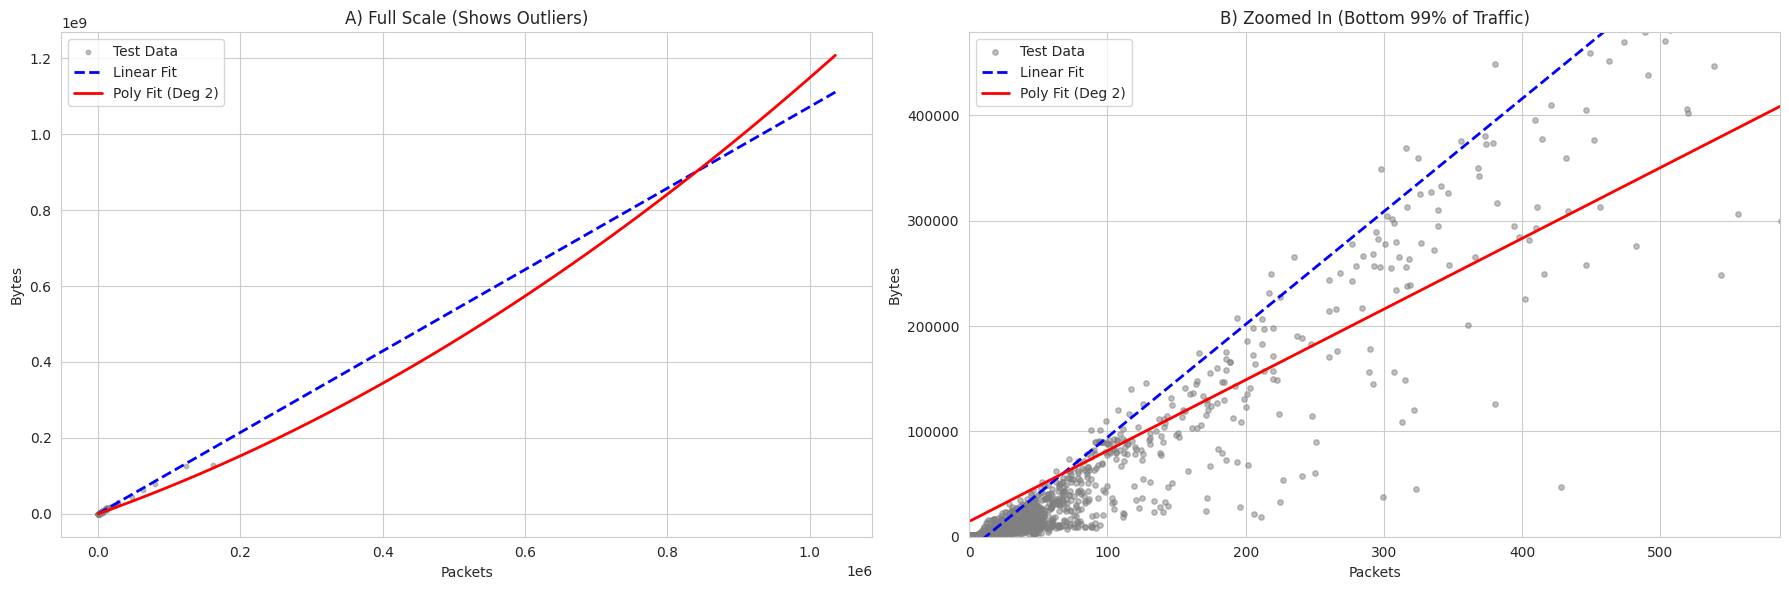

In [17]:
# --- CELL 6: POLYNOMIAL REGRESSION (WITH ZOOMED PLOT) ---

# 1. Setup Data
X = df[['packets']]
y = df['bytes']

# Split data (80% Train, 20% Test)
# We sort X_test for smoother plotting later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Linear Model (Degree 1) - Baseline
lin_reg = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred_lin = lin_reg.predict(sm.add_constant(X_test))
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# 3. Polynomial Model (Degree 2)
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Fit model
poly_reg = sm.OLS(y_train, X_poly_train).fit()
y_pred_poly = poly_reg.predict(X_poly_test)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

# 4. Print Comparison
print(f"Linear Regression RMSE: {rmse_lin:,.2f}")
print(f"Polynomial Regression (Deg 2) RMSE: {rmse_poly:,.2f}")
print("-" * 30)
if rmse_poly < rmse_lin:
    print("Result: Polynomial regression fits BETTER.")
else:
    print("Result: Polynomial regression fits WORSE (Overfitting).")

# 5. Visualization (Side-by-Side)
# Create a smooth range for plotting lines
X_range_vals = np.linspace(X.min().iloc[0], X.max().iloc[0], 100)
X_range_df = pd.DataFrame(X_range_vals, columns=['packets'])

# Predict for lines
y_range_lin = lin_reg.predict(sm.add_constant(X_range_df))
y_range_poly = poly_reg.predict(poly.transform(X_range_df))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Plot A: Full Scale ---
axes[0].scatter(X_test, y_test, color='gray', alpha=0.5, label='Test Data', s=10)
axes[0].plot(X_range_df, y_range_lin, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axes[0].plot(X_range_df, y_range_poly, color='red', linewidth=2, label='Poly Fit (Deg 2)')
axes[0].set_title('A) Full Scale (Shows Outliers)')
axes[0].set_xlabel('Packets')
axes[0].set_ylabel('Bytes')
axes[0].legend()

# --- Plot B: Zoomed In (99th Percentile) ---
# Calculate limits to zoom in on the "dense" part of the data
p99_x = np.percentile(X_test, 99)
p99_y = np.percentile(y_test, 99)

axes[1].scatter(X_test, y_test, color='gray', alpha=0.5, label='Test Data', s=15)
axes[1].plot(X_range_df, y_range_lin, color='blue', linewidth=2, linestyle='--', label='Linear Fit')
axes[1].plot(X_range_df, y_range_poly, color='red', linewidth=2, label='Poly Fit (Deg 2)')

# Force the zoom
axes[1].set_xlim(0, p99_x)
axes[1].set_ylim(0, p99_y)

axes[1].set_title('B) Zoomed In (Bottom 99% of Traffic)')
axes[1].set_xlabel('Packets')
axes[1].set_ylabel('Bytes')
axes[1].legend()

plt.tight_layout()
plt.show()

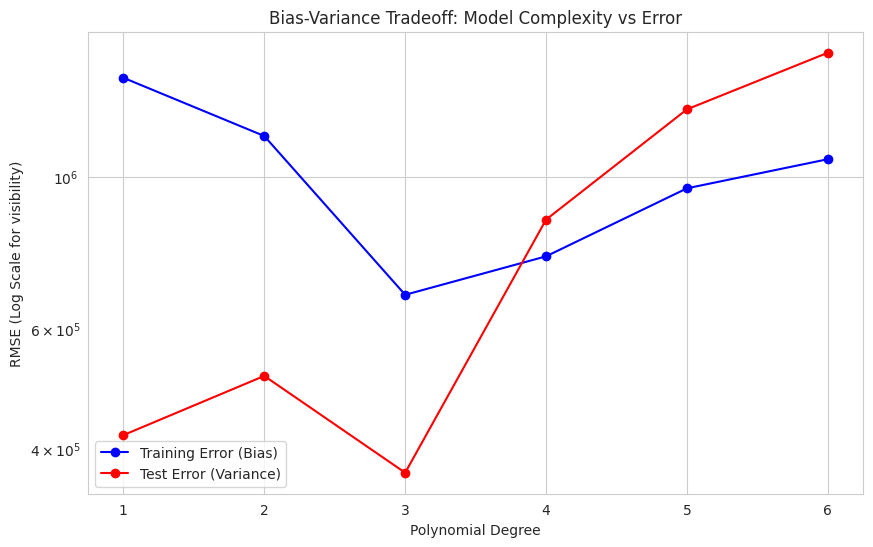

In [23]:
# --- CELL 6.5: MODEL COMPLEXITY (BIAS-VARIANCE TRADEOFF) ---

degrees = [1, 2, 3, 4, 5, 6]
train_errors = []
test_errors = []

# Loop through degrees
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    model = sm.OLS(y_train, X_poly_train).fit()

    # Calculate RMSE
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Plotting the "U-Shape" (or Divergence)
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, 'b-o', label='Training Error (Bias)')
plt.plot(degrees, test_errors, 'r-o', label='Test Error (Variance)')

plt.title('Bias-Variance Tradeoff: Model Complexity vs Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE (Log Scale for visibility)')
plt.yscale('log') # Log scale helps if errors explode at high degrees
plt.xticks(degrees)
plt.legend()
plt.grid(True)
plt.show()

## Checking for Project Requirements

In [29]:
# --- CELL 7: Checking for Project Requirements ---
# This cell extracts results from the previous models to answer the assignment questions dynamically.

print("========================================================================================")
print("                       COURSE PROJECT 1 - FINAL REPORT SUMMARY")
print("========================================================================================")

# --- SECTION 1: Single Predictor ---
print("\n1. Apply Linear Regression to Single Predictor (Source Code: Cell 4)")
print("-" * 90)
# 1a: Coefficients & RSS
print(f"a) Estimate coefficients and RSS:")
print(f"   - Intercept (b0): {model_simple.params['const']:.4f}")
print(f"   - Slope (b1) for Packets: {model_simple.params['packets']:.4f}")
print(f"   - Residual Sum of Squares (RSS): {model_simple.ssr:,.2f}")

# 1b: t-stat and p-value
print(f"\nb) Calculate t-statistic and p-value:")
print(f"   - t-statistic (for packets): {model_simple.tvalues['packets']:.4f}")
print(f"   - p-value: {model_simple.pvalues['packets']:.4e}")
print(f"     (Is it significant? {'YES' if model_simple.pvalues['packets'] < 0.05 else 'NO'})")

# 1c: Accuracy
print(f"\nc) Assess Overall Accuracy:")
print(f"   - R-squared: {model_simple.rsquared:.4f} (The model explains {model_simple.rsquared*100:.2f}% of the variance)")
print(f"   - Residual Standard Error (RSE): {np.sqrt(model_simple.mse_resid):,.2f}")
print(f"   - Correlation (r): {np.sqrt(model_simple.rsquared):.4f}")


# --- SECTION 2: Multiple Predictors ---
print("\n\n2. Apply Linear Regression to Multiple Predictors (Source Code: Cell 5)")
print("-" * 90)

# 2a: Global F-test
is_significant = model_multi.f_pvalue < 0.05
print(f"a) Is at least one predictor useful? (Global F-test)")
print(f"   - F-statistic p-value: {model_multi.f_pvalue:.4e}")
print(f"   - Answer: {'YES' if is_significant else 'NO'} (Since p-value < 0.05, at least one predictor is useful).")

# 2b: Individual Predictors
print(f"\nb) Do all predictors help to explain Y?")
print("   - Individual p-values:")
for feature, p in model_multi.pvalues.items():
    if feature != 'const':
        status = "USEFUL (Significant)" if p < 0.05 else "NOT USEFUL (Not Significant)"
        print(f"     * {feature}: p={p:.4e} -> {status}")

# 2c: Model Fit
print(f"\nc) How well does the model fit the data?")
print(f"   - R-squared: {model_multi.rsquared:.4f}")
print(f"   - Adj. R-squared: {model_multi.rsquared_adj:.4f} (Adjusted for number of predictors)")

# 2d: Prediction Accuracy
print(f"\nd) Prediction Example & Accuracy:")
# Create a hypothetical average connection for prediction
ex_data = X_multi.mean().to_frame().T
ex_data = sm.add_constant(ex_data, has_constant='add')
pred_summary = model_multi.get_prediction(ex_data).summary_frame(alpha=0.05)
print(f"   - For an average connection, the model predicts: {pred_summary['mean'][0]:,.2f} bytes")
print(f"   - Raw 95% Prediction Interval: [{pred_summary['obs_ci_lower'][0]:,.2f}, {pred_summary['obs_ci_upper'][0]:,.2f}]")
# If the lower bound is negative (rare but possible with linear models), clamp it to 0 because bytes cannot be negative.
lower_bound = max(0, pred_summary['obs_ci_lower'][0]) # Ensure no negative bytes
print(f"   - 95% Prediction Interval: [{lower_bound:,.2f}, {pred_summary['obs_ci_upper'][0]:,.2f}]")
print("     (This interval represents the range where a new observation is likely to fall.)")

# 2e: Interactions
print(f"\ne) Analyze Interactions (Action vs Packets):")
# Check for any significant interaction terms
interaction_terms = [idx for idx in interaction_model.pvalues.index if ':' in idx]
sig_interactions = [term for term in interaction_terms if interaction_model.pvalues[term] < 0.05]

if sig_interactions:
    print(f"   - Significant Interaction Found: YES")
    print(f"   - Terms: {sig_interactions}")
    print("   - Interpretation: The relationship between Packets and Bytes CHANGES depending on the 'Action' (Allow/Drop).")
else:
    print("   - Significant Interaction Found: NO")


# --- SECTION 3: Polynomial Regression ---
print("\n\n3. Apply Polynomial Regression Model (Source Code: Cell 6)")
print("-" * 90)
print(f"   - Linear Model RMSE: {rmse_lin:,.2f}")
print(f"   - Polynomial Model RMSE: {rmse_poly:,.2f}")
print(f"   - Comparison Result: {'Polynomial is BETTER' if rmse_poly < rmse_lin else 'Linear is BETTER'}")
if rmse_poly > rmse_lin:
    print("   - Note: The polynomial model performed worse, likely due to overfitting or the data being strictly linear.")

print("\n========================================================================================")


                       COURSE PROJECT 1 - FINAL REPORT SUMMARY

1. Apply Linear Regression to Single Predictor (Source Code: Cell 4)
------------------------------------------------------------------------------------------
a) Estimate coefficients and RSS:
   - Intercept (b0): -12585.5662
   - Slope (b1) for Packets: 1066.5281
   - Residual Sum of Squares (RSS): 104,640,014,180,666,208.00

b) Calculate t-statistic and p-value:
   - t-statistic (for packets): 1109.0174
   - p-value: 0.0000e+00
     (Is it significant? YES)

c) Assess Overall Accuracy:
   - R-squared: 0.9494 (The model explains 94.94% of the variance)
   - Residual Standard Error (RSE): 1,263,655.85
   - Correlation (r): 0.9744


2. Apply Linear Regression to Multiple Predictors (Source Code: Cell 5)
------------------------------------------------------------------------------------------
a) Is at least one predictor useful? (Global F-test)
   - F-statistic p-value: 0.0000e+00
   - Answer: YES (Since p-value < 0.05, at